# Milestone P3

In [20]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from wordcloud import WordCloud
from itertools import chain
from collections import Counter

import statsmodels.api as stm
import statsmodels.formula.api as smf

import networkx as nx
from IPython.display import Image, display

from PIL import Image

## Abstract

## Part 1: Data familiarization

### Part 1.1: Loading data

### Part 1.2: Data scraping

### Part 1.3: Role identification

## Part 2: Data preprocessing

### Part 2.1: Adapt to inflation

### Part 2.2: Clear absurdities

### Part 2.3: Format languages/countries/genres/ethnicities

### Part 2.4: One-hot encoding of categorical features

## Part 3: Features study

### Part 3.1: Gender study

In this section, we will explore the relevance of predicting the revenue or rating of a movie by using the gender of the cast.

#### Data importation and general cleaning

Here is the character data:

In [2]:
characters_classified = pd.read_csv('../Clean data/character_classification.csv')
characters_classified.head()

,Wiki ID,Freebase ID,Release date,Character name,Actor DOB,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at release,Map ID,Character ID,Actor ID,Role
0,5894429,/m/0fc8w8,2007-09-14,Ethel Ann,1934-04-24,F,1.700,NaN,Shirley MacLaine,73.0,/m/0jwjk9,/m/0h129m6,/m/01w1kyf,Primary
1,5894429,/m/0fc8w8,2007-09-14,Young Ethel Ann,1986-01-24,F,1.750,/m/09vc4s,Mischa Barton,21.0,/m/0jwjkg,/m/0gy6lpz,/m/01qn8k,Secondary
2,27556929,/m/04j0jtp,1996,Kingsley Ofusu,1973-07-20,M,1.778,/m/0x67,Omar Epps,22.0,/m/04j0jts,/m/0h2j4r7,/m/02_tv5,Secondary
3,27556929,/m/04j0jtp,1996,Vlachos,1946-05-02,M,1.700,/m/02w7gg,David Suchet,49.0,/m/0cg0qq4,/m/0h2t3nh,/m/013bd1,Primary
4,27463222,/m/0c037x9,2010-09-12,Paul,1964-07-22,M,1.730,/m/025rpb0,John Leguizamo,46.0,/m/0c05h8f,/m/0gdjxq3,/m/04yj5z,Secondary


Here are three functions. The first one transforms a dictionary into a list; it is useful to be able to use the genre, country and language columns of the movie dataset. The second one extracts the first item of a list of items. The last one is a clustering algorithm that groups together movie genres which are similar:

In [3]:
def dict_to_list(data, column):
    # Filter the data where the specified column is not null
    filtered_data = data[data[column].notnull()]
    
    # Apply regex to extract specific patterns from the column values
    filtered_data[column] = filtered_data[column].apply(lambda x: re.findall(r'": "(.*?)"', x))
    
    return filtered_data

def extract_first_item(genre_list):
    # Return the first item (or None if the list is empty)
    if isinstance(genre_list, list) and len(genre_list) > 0:
        return genre_list[0]
    else:
        return None
    
def clean_genres(movies):
    for index, row in movies.iterrows():
        # Comedy genres
        if 'Comedy-drama' in row['Genres']:
            if 'Comedy' in row['Genres'] and 'Drama' in row['Genres']:
                row['Genres'].remove('Comedy-drama')
            elif 'Comedy' in row['Genres'] and 'Drama' not in row['Genres']:
                row['Genres'][row['Genres'].index('Comedy-drama')] = 'Drama'
            elif 'Drama' in row['Genres'] and 'Comedy' not in row['Genres']:
                row['Genres'][row['Genres'].index('Comedy-drama')] = 'Comedy'
            else:
                row['Genres'].remove('Comedy-drama')
                row['Genres'].extend(['Comedy', 'Drama'])

        # Romance genres
        if 'Romantic comedy' in row['Genres']:
            if 'Romance Film' in row['Genres'] and 'Comedy' in row['Genres']:
                row['Genres'].remove('Romantic comedy')
            elif 'Comedy' in row['Genres'] and 'Romance Film' not in row['Genres']:
                row['Genres'][row['Genres'].index('Romantic comedy')] = 'Romance Film'
            elif 'Romance Film' in row['Genres'] and 'Comedy' not in row['Genres']:
                row['Genres'][row['Genres'].index('Romantic comedy')] = 'Comedy'
            else:
                row['Genres'].remove('Romantic comedy')
                row['Genres'].extend(['Comedy', 'Romance Film'])

        # Drama genres
        if 'Romantic drama' in row['Genres']:
            if 'Romance Film' in row['Genres'] and 'Drama' in row['Genres']:
                row['Genres'].remove('Romantic drama')
            elif 'Drama' in row['Genres'] and 'Romance Film' not in row['Genres']:
                row['Genres'][row['Genres'].index('Romantic drama')] = 'Romance Film'
            elif 'Romance Film' in row['Genres'] and 'Drama' not in row['Genres']:
                row['Genres'][row['Genres'].index('Romantic drama')] = 'Drama'
            else:
                row['Genres'].remove('Romantic drama')
                row['Genres'].extend(['Drama', 'Romance Film'])

        # Action genres
        if 'Action/Adventure' in row['Genres']:
            if 'Action' in row['Genres'] and 'Adventure' in row['Genres']:
                row['Genres'].remove('Action/Adventure')
            elif 'Action' in row['Genres'] and 'Adventure' not in row['Genres']:
                row['Genres'][row['Genres'].index('Action/Adventure')] = 'Adventure'
            elif 'Adventure' in row['Genres'] and 'Action' not in row['Genres']:
                row['Genres'][row['Genres'].index('Action/Adventure')] = 'Action'
            else:
                row['Genres'].remove('Action/Adventure')
                row['Genres'].extend(['Action', 'Adventure'])

        # Redundant genres
        if 'Comedy film' in row['Genres']:
            if 'Comedy' in row['Genres']:
                row['Genres'].remove('Comedy film')
            else:
                row['Genres'].remove('Comedy film')
                row['Genres'].extend('Comedy')

    return movies

Here is the movie data. We directly apply the dictionary to list algorithms on the columns of interest so that they become useable:

In [4]:
movie_data = pd.read_csv('../Clean data/clean_movie_data_corrected.csv')

# Create lists for genres, languages and countries
movie_data = dict_to_list(movie_data, 'Genres')
movie_data = dict_to_list(movie_data, 'Languages')
movie_data = dict_to_list(movie_data, 'Countries')

movie_data.head()

,Wiki ID,Freebase ID,Movie name,Release date,Revenue,Runtime,Languages,Countries,Genres,IMDb rating,Wins,Nominations
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",4.9,0.0,2.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",6.0,0.0,0.0
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",5.9,0.0,0.0
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",6.9,1.0,6.0
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...",5.8,0.0,0.0


#### Word cloud of movie genres depending on actor gender

We are interested in identifying the most common movie genres if:
- the primary character is a man
- the primary character is a woman
- the secondary character is a man
- the secondary character is a woman

Therefore, we will make a word cloud containing the 20 most common movie genres for these 4 cases.

First, let us only keep the important columns of the character data, i.e. the gender and role:

In [5]:
to_keep = ['Wiki ID', 'Actor gender', 'Role']
characters_classified_0 = characters_classified[to_keep]

characters_classified_0.head()

,Wiki ID,Actor gender,Role
0,5894429,F,Primary
1,5894429,F,Secondary
2,27556929,M,Secondary
3,27556929,M,Primary
4,27463222,M,Secondary


Same for the movie data, i.e. the genre. Since the word cloud will recognise individual words, we have to connect multi-word genres with underscores:

In [6]:
to_keep = ['Wiki ID', 'Genres']
movie_data_0 = movie_data[to_keep]

wordcloud_data = clean_genres(movie_data_0)

# Define a function to replace spaces with underscores in a list of strings
def replace_spaces_with_underscores(string_list):
    return [s.replace(' ', '_') for s in string_list]

# Apply the function to the genre column
movie_data_0['Genres'] = movie_data_0['Genres'].apply(replace_spaces_with_underscores)

movie_data_0.head()

C:\Users\aouzi\AppData\Local\Temp\ipykernel_3712\1643083096.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data_0['Genres'] = movie_data_0['Genres'].apply(replace_spaces_with_underscores)


,Wiki ID,Genres
0,975900,"[Thriller, Science_Fiction, Horror, Adventure,..."
1,3196793,"[Mystery, Biographical_film, Drama, Crime_Drama]"
2,13696889,"[Short_Film, Silent_film, Indie, Black-and-whi..."
3,10408933,"[Musical, Comedy, Black-and-white]"
4,6631279,"[Ensemble_Film, Drama, Comedy, Romance_Film]"


Now let us merge both movie and character info to create the wordcloud. Then, we can keep the 20 most common genres that appear in this data:

In [8]:
wordcloud_data = pd.merge(characters_classified_0, movie_data_0, on='Wiki ID')

def keep_common_genres(df):
    # Step 1: Flatten the lists of genres
    flat_genres = list(chain.from_iterable(df['Genres']))

    # Step 2: Count the occurrences of each genre
    genre_counts = Counter(flat_genres)

    # Step 3: Select the top 20 genres
    top_genres = [genre for genre, count in genre_counts.most_common(20)]

    # Step 4: Filter the original lists of genres
    df['Genres'] = df['Genres'].apply(lambda genres: [genre for genre in genres if genre in top_genres])

keep_common_genres(wordcloud_data)

wordcloud_data.head()

,Wiki ID,Actor gender,Role,Genres
0,5894429,F,Primary,"[Romance_Film, Drama]"
1,5894429,F,Secondary,"[Romance_Film, Drama]"
2,27463222,M,Secondary,"[Thriller, Horror, Mystery]"
3,27463222,M,Primary,"[Thriller, Horror, Mystery]"
4,4069274,F,Primary,"[Drama, Romance_Film, Indie]"


The following function takes a dataframe containing movies with either male or female actors in either the primary or secondary role, and genreates the wordcloud by counting the frequency of appearance of all 20 genres in the data:

In [9]:
def create_wordcloud(data, mask, color):
    # Flatten the lists of genres
    flat_genres = [genre for genres in data['Genres'] for genre in genres]

    # Count the occurrences of each genre
    genre_counts = pd.Series(flat_genres).value_counts()

    # Create a WordCloud object with the frequencies
    wordcloud = WordCloud(background_color='white', mask=mask, height=800, width=600, contour_width = 3,\
    contour_color = color).generate_from_frequencies(genre_counts)

    return wordcloud

This function creates a mask out of an image that we want to use as the container for our wordcloud. Our goal is to place the clouds that pertain to male actor data inside of a man's silhouette, and vice-versa for female actors:

In [10]:
def transform_mask(imagename):
    mask = np.array(Image.open(imagename))
    # Transform 3d image to 2d for easier visualisation
    mask = mask[:,:,0]

    def transform_format(val):
        if val.any()== 0:
            return 255
        else:
            return val

    # Transform mask into a new one that will work with the function
    transformed_mask = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)

    for i in range(len(mask)):
        transformed_mask[i] = list(map(transform_format,mask[i]))

    return transformed_mask

Now we can split the data into the four categories and create all the wordclouds:

In [11]:
pm = wordcloud_data[(wordcloud_data['Actor gender'] == 'M') & (wordcloud_data['Role'] == 'Primary')]
pf = wordcloud_data[(wordcloud_data['Actor gender'] == 'F') & (wordcloud_data['Role'] == 'Primary')]
sm = wordcloud_data[(wordcloud_data['Actor gender'] == 'M') & (wordcloud_data['Role'] == 'Secondary')]
sf = wordcloud_data[(wordcloud_data['Actor gender'] == 'F') & (wordcloud_data['Role'] == 'Secondary')]

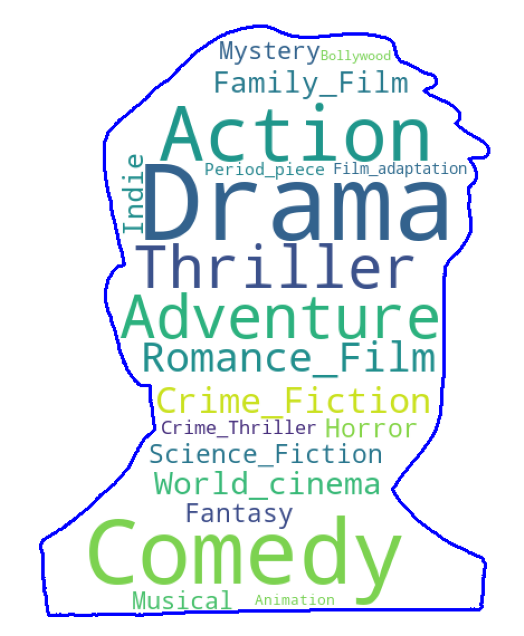

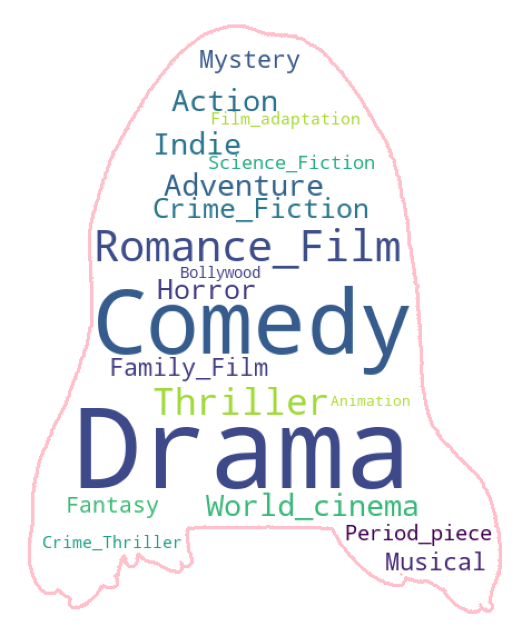

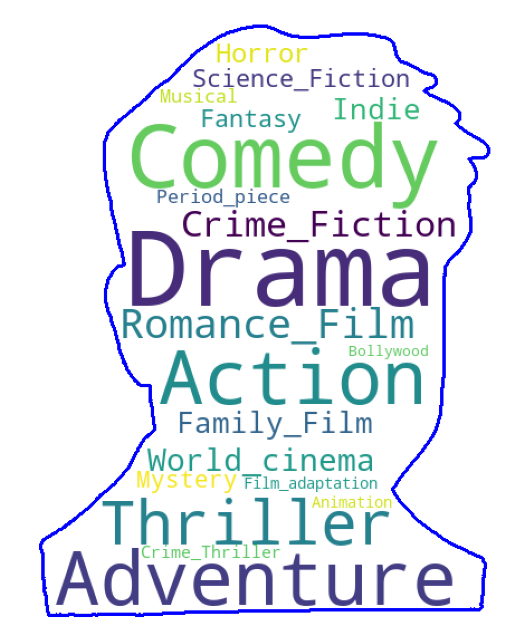

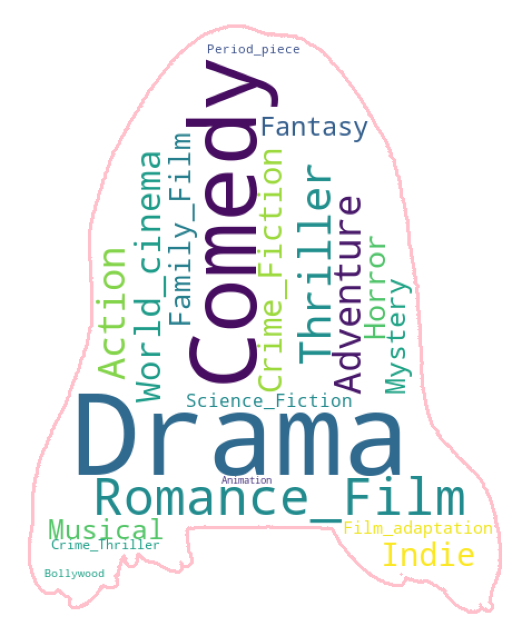

In [12]:
mask = np.array(Image.open("../../HTML JS PY Test/assets/img/brad.png"))
mask_trans = mask[:, :, 0]
mask_trans = transform_mask("../../HTML JS PY Test/assets/img/brad.png")
title_wordcloud = create_wordcloud(pm, mask_trans, 'blue')
title_wordcloud.to_file("pm.png")
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

mask = np.array(Image.open("../../HTML JS PY Test/assets/img/angie.png"))
mask_trans = mask[:, :, 0]
mask_trans = transform_mask("../../HTML JS PY Test/assets/img/angie.png")
title_wordcloud = create_wordcloud(pf, mask_trans, 'pink')
title_wordcloud.to_file("pf.png")
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

mask = np.array(Image.open("../../HTML JS PY Test/assets/img/brad.png"))
mask_trans = mask[:, :, 0]
mask_trans = transform_mask("../../HTML JS PY Test/assets/img/brad.png")
title_wordcloud = create_wordcloud(sm, mask_trans, 'blue')
title_wordcloud.to_file("sm.png")
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

mask = np.array(Image.open("../../HTML JS PY Test/assets/img/angie.png"))
mask_trans = mask[:, :, 0]
mask_trans = transform_mask("../../HTML JS PY Test/assets/img/angie.png")
title_wordcloud = create_wordcloud(sf, mask_trans, 'pink')
title_wordcloud.to_file("sf.png")
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

#### Linear regression of revenue/rating with respect to gender of primary/secondary role

The goal now is to figure out if there is a difference of importance between primary and secondary role gender in predicting revenue or rating of a movie. therefore, we will perform linear regression on the data `Revenue/Rating ~ PrimaryRoleGender + SecondaryRoleGender`.

First, we take the character data and keep the relevant columns, i.e. gender and role:

In [13]:
to_keep = ['Wiki ID', 'Actor gender', 'Role']
characters_classified_2 = characters_classified[to_keep]

characters_classified_2.head()

,Wiki ID,Actor gender,Role
0,5894429,F,Primary
1,5894429,F,Secondary
2,27556929,M,Secondary
3,27556929,M,Primary
4,27463222,M,Secondary


We can also just keep the revenue and rating of each movie in the data:

In [14]:
to_keep = ['Wiki ID', 'Revenue', 'IMDb rating']
movie_data_2 = movie_data[to_keep]

movie_data_2.head()

,Wiki ID,Revenue,IMDb rating
0,975900,14010832.0,4.9
1,3196793,NaN,6.0
2,13696889,NaN,5.9
3,10408933,3600000.0,6.9
4,6631279,NaN,5.8


Now, the regression data is the merged character and movie data:

In [15]:
regression_data = pd.merge(movie_data_2, characters_classified_2, on='Wiki ID')

regression_data.head()

,Wiki ID,Revenue,IMDb rating,Actor gender,Role
0,975900,14010832.0,4.9,F,Primary
1,975900,14010832.0,4.9,M,Secondary
2,6631279,NaN,5.8,F,Secondary
3,6631279,NaN,5.8,F,Primary
4,171005,10161099.0,7.5,M,Primary


The following function prepares the dataframe for the regression by transforming the gender of the actors into a binary variable (1 for Male and 0 for Female) and renaming the columns:

In [16]:
def prepare_regression_df(original_df):
    # Pivot the DataFrame to separate primary and secondary roles
    pivot_df = original_df.pivot(index='Wiki ID', columns='Role', values=['Actor gender'])

    # Flatten the MultiIndex columns
    pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]

    # Reset the index to make movie_id a regular column
    pivot_df.reset_index(inplace=True)

    # Merge with the original DataFrame on movie_id
    final_df = pd.merge(original_df[['Wiki ID', 'Revenue', 'IMDb rating']], pivot_df, on='Wiki ID')

    # Rename columns for clarity
    final_df = final_df.rename(columns={'Actor gender_Primary': 'Primary gender', 'Actor gender_Secondary': 'Secondary gender'})

    # Change genders to numerical values
    final_df['Primary gender'] = final_df['Primary gender'].replace({'M': 1, 'F': 0})
    final_df['Secondary gender'] = final_df['Secondary gender'].replace({'M': 1, 'F': 0})

    return final_df

Now we can treat the regression data:

In [30]:
treated_regression_data = prepare_regression_df(regression_data)

# Drop NaN values since the regression cannot handle them correctly
treated_regression_data = treated_regression_data.dropna()
treated_regression_data = treated_regression_data.reset_index(drop=True)

treated_regression_data.head()

,Wiki ID,Revenue,IMDb rating,Primary gender,Secondary gender
0,975900,14010832.0,4.9,0.0,1.0
1,975900,14010832.0,4.9,0.0,1.0
2,171005,10161099.0,7.5,1.0,0.0
3,171005,10161099.0,7.5,1.0,0.0
4,77856,102272727.0,7.8,1.0,1.0


Here is the function for the regression. We can either fit the revenue or the rating based on the gender of the peimary and secondary roles:

In [21]:
def linear_regression(data, input_columns, output_column):
    """
    Perform linear regression on the specified DataFrame.

    Parameters:
    - data (pd.DataFrame): The input DataFrame.
    - input_columns (list): List of column names to be used as input features.
    - output_column (str): The column name to be used as the output variable.

    Returns:
    - results (statsmodels.regression.linear_model.RegressionResults): Regression results summary.
    """

    # Select input and output columns
    X = data[input_columns]
    y = data[output_column]

    # Add a constant term to the input features for the intercept
    X = stm.add_constant(X)

    # Fit the linear regression model
    model = stm.OLS(y, X)
    results = model.fit()

    # Print a summary of the regression results
    print(results.summary())

    return results

Here are both results:

In [25]:
regression_revenue = linear_regression(treated_regression_data, ['Primary gender', 'Secondary gender'], 'Revenue')

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.679
Date:                Fri, 22 Dec 2023   Prob (F-statistic):            0.00934
Time:                        00:35:45   Log-Likelihood:                -79109.
No. Observations:                3964   AIC:                         1.582e+05
Df Residuals:                    3961   BIC:                         1.582e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             5.145e+07   3.94e+06  

In [26]:
regression_rating  = linear_regression(treated_regression_data, ['Primary gender', 'Secondary gender'], 'IMDb rating')

                            OLS Regression Results                            
Dep. Variable:            IMDb rating   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     10.34
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           3.32e-05
Time:                        00:35:48   Log-Likelihood:                -5932.3
No. Observations:                3964   AIC:                         1.187e+04
Df Residuals:                    3961   BIC:                         1.189e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.2364      0.038  

We see that, for both output variables revenue and rating, the p-value for the fitted coefficient of the secondary role gender is very high (0.227 for revenue and 0.472 for rating). Therefore, we can say that it is way less statistically significant to use secondary role gender to predict the outputs than it is to use primary role gender. This is why we will now only focus on the gender of the primary role.

#### Proportion of men/women actors in primary role compared to revenue/rating

Here, we will, for each genre of movies, compute the average revenue/rating for movies featuring a male primary actor and a female primary actor, and observe the difference.

As usual, let us keep the relevant columns, i.e. gender and role:

In [27]:
to_keep = ['Wiki ID', 'Actor gender', 'Role']
characters_classified_1 = characters_classified[to_keep]

characters_classified_1.head()

,Wiki ID,Actor gender,Role
0,5894429,F,Primary
1,5894429,F,Secondary
2,27556929,M,Secondary
3,27556929,M,Primary
4,27463222,M,Secondary


For the movie data, we can just keep the genre, revenue and rating:

In [28]:
to_keep = ['Wiki ID', 'Genres', 'Revenue', 'IMDb rating']
movie_data_1 = movie_data[to_keep]

movie_data_1.head()

,Wiki ID,Genres,Revenue,IMDb rating
0,975900,"[Thriller, Science Fiction, Horror, Adventure,...",14010832.0,4.9
1,3196793,"[Mystery, Biographical film, Drama, Crime Drama]",NaN,6.0
2,13696889,"[Short Film, Silent film, Indie, Black-and-whi...",NaN,5.9
3,10408933,"[Musical, Comedy, Black-and-white]",3600000.0,6.9
4,6631279,"[Ensemble Film, Drama, Comedy, Romance Film]",NaN,5.8


We can cluster the genres using the function defined above:

In [41]:
# Cluster the genres that are similar and remove redundant genre names
movies_with_genres = clean_genres(movie_data_1).copy()

movies_with_genres.head()

,Wiki ID,Genres,Revenue,IMDb rating
0,975900,"[Thriller, Science Fiction, Horror, Adventure,...",14010832.0,4.9
1,3196793,"[Mystery, Biographical film, Drama, Crime Drama]",NaN,6.0
2,13696889,"[Short Film, Silent film, Indie, Black-and-whi...",NaN,5.9
3,10408933,"[Musical, Comedy, Black-and-white]",3600000.0,6.9
4,6631279,"[Ensemble Film, Drama, Comedy, Romance Film]",NaN,5.8


We can now merge the character and movie dataframes to create the final data. We also drop rows containing NaN values and remove the Wiki ID column that was only useful for the merging:

In [42]:
characters_with_genres = pd.merge(movies_with_genres, characters_classified_1, on='Wiki ID')
characters_with_genres = characters_with_genres.dropna()
characters_with_genres = characters_with_genres.drop('Wiki ID', axis=1)

characters_with_genres.head()

,Genres,Revenue,IMDb rating,Actor gender,Role
0,"[Thriller, Science Fiction, Horror, Adventure,...",14010832.0,4.9,F,Primary
1,"[Thriller, Science Fiction, Horror, Adventure,...",14010832.0,4.9,M,Secondary
4,"[Costume drama, War film, Epic, Period piece, ...",10161099.0,7.5,M,Primary
5,"[Costume drama, War film, Epic, Period piece, ...",10161099.0,7.5,F,Secondary
6,"[Children's/Family, Musical, Fantasy, Comedy, ...",102272727.0,7.8,M,Secondary


This function filters a particular column of a given dataframe to only keep the `n` most common values in the data:

In [43]:
def filter_n_common(data, n, column):
    # Algorithm to perform if the column is a column of genres
    if column == 'Genres':
        # Count genre occurrences
        genre_counts = data['Genres'].explode().value_counts()

        # Get the top N genres
        top_n_genres = genre_counts.head(n).index.tolist()

        # Function to filter genres in a list
        def filter_genres(genre_list):
            return [genre for genre in genre_list if genre in top_n_genres]

        # Apply the filtering function to the 'Genres' column
        data['Genres'] = data['Genres'].apply(filter_genres)

        # Remove rows with empty 'Genre' lists
        data = data[data['Genres'].astype(bool)]

        return data
    
    # Algorithm to perform if the column contains other values e.g. countries or languages
    else:
        # Find the n most frequent values
        top_values = data[column].value_counts().nlargest(n).index.tolist()
        print(top_values)

        # Filter the DataFrame to keep rows with one of the top values
        filtered_df = data[data[column].isin(top_values)]

        return filtered_df

Now we filter the 10 most common genres, rename the columns to yield a more understandable dataframe, and rename the values in the gender column:

In [44]:
characters_with_best_genres = filter_n_common(characters_with_genres, 10, 'Genres').copy()
characters_with_best_genres = characters_with_best_genres.reset_index(drop=True)

characters_with_best_genres.rename(columns={'Actor gender': 'Gender', 'IMDb rating': 'Rating'}, inplace=True)
characters_with_best_genres['Gender'] = characters_with_best_genres['Gender'].replace({'M': 'Male', 'F': 'Female'})

characters_with_best_genres.head()

,Genres,Revenue,Rating,Gender,Role
0,"[Thriller, Horror, Adventure, Action]",14010832.0,4.9,Female,Primary
1,"[Thriller, Horror, Adventure, Action]",14010832.0,4.9,Male,Secondary
2,[Drama],10161099.0,7.5,Male,Primary
3,[Drama],10161099.0,7.5,Female,Secondary
4,"[Comedy, Drama]",102272727.0,7.8,Male,Secondary


Now, this function below plots the histogram: for each movie genre, we will have three bars:
- the average revenue/rating where primary role is a man
- the average revenue/rating where primary role is a woman
- the difference between both averages (man - woman)

In [47]:
def plot_gender_revenue_difference(df, column):
    """
    Plot a histogram for each genre showing the average revenue for movies
    with male and female primary actors, and the difference between them.

    Parameters:
    - df: DataFrame containing columns 'Genre', 'Gender', and 'Revenue'.
    """

    # Explode the genres to have one row per genre (so that movies with several count for all of their genres)
    df_duplicated = df.explode('Genres')

    # Group by Genre and Gender and calculate the average revenue and standard deviation
    grouped_df = df_duplicated.groupby(['Genres', 'Gender']).agg({column: ['mean', 'std']}).reset_index()

    # Pivot the DataFrame to have Gender as columns
    pivot_df = grouped_df.pivot(index='Genres', columns='Gender').reset_index()

    # Calculate the difference between male and female average revenues
    pivot_df['Difference'] = pivot_df[column]['mean']['Male'] - pivot_df[column]['mean']['Female']

    # Define the order of genres
    genre_order = df_duplicated['Genres'].unique()

    # Plot the bar chart with error bars only on the difference bars
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Plot bars for male and female average revenues on the primary y-axis
    sns.barplot(x='Genres', y=column, hue='Gender', data=df_duplicated, ax=ax1, palette={'Male': 'blue', 'Female': 'pink'}, order=genre_order)

    # Create a secondary y-axis for the difference bars
    ax2 = ax1.twinx()

    # Plot the bar for the difference in average revenues on the secondary y-axis with error bars
    sns.barplot(x='Genres', y='Difference', data=pivot_df, ax=ax2, color='gray', alpha=0.5, order=genre_order)

    # Set the correct bounds for axes depending on column
    if column == 'Revenue':
        ax1.set_ylim(bottom=0, top=20e7)
        ax2.set_ylim(bottom=-10e7, top=6e7)
        ax2.grid(False)
    else:
        ax1.set_ylim(bottom=0, top=20)
        ax2.set_ylim(bottom=-1.25, top=.75)
        ax2.grid(False)

    # Move the legends to the top left corner
    ax1.legend(loc='upper left')

    # Set legend for the secondary y-axis manually
    ax2.legend([ax2.patches[0]], ['Difference'], loc='upper right')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Add labels and title
    ax1.set_xlabel('Genres')
    ax1.set_ylabel('Average ' + column + ' (Male/Female)', color='black')
    ax2.set_ylabel('Difference in Average ' + column, color='gray')
    ax1.set_title('Average ' + column + ' by Genre and Gender')

    '''
    # Print the heights of the bars on the primary y-axis
    for p in ax1.patches:
        print(f"Height of bar at {p.get_x() + p.get_width() / 2}: {p.get_height()}")
    print(" ")
    for p in ax2.patches:
        print(f"Height of bar at {p.get_x() + p.get_width() / 2}: {p.get_height()}")
    '''

    plt.show()

Here are both plots for revenue and rating:

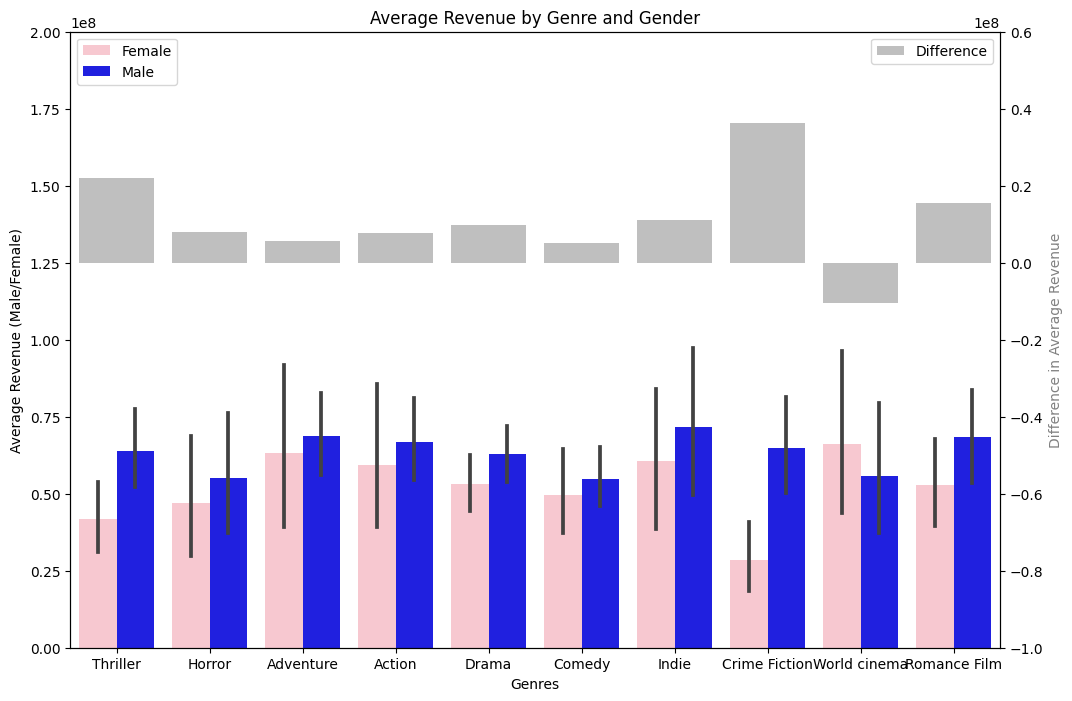

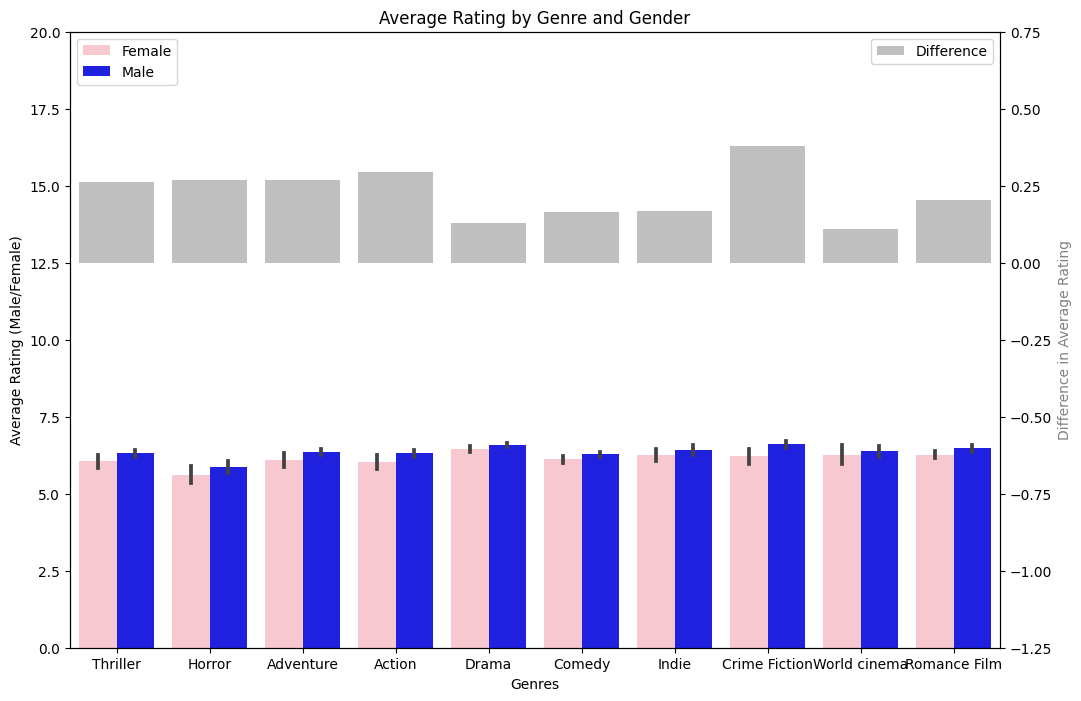

In [46]:
plot_gender_revenue_difference(characters_with_best_genres[characters_with_best_genres['Role'] == 'Primary'], 'Revenue')
plot_gender_revenue_difference(characters_with_best_genres[characters_with_best_genres['Role'] == 'Primary'], 'Rating')

As we can see, the difference in revenue is quite noticeable for almost every selected genre. In other words, the revenue of a movie seems to be greatly impacted on the fact of casting a man or a woman as the primary role. Note that the only genre where a female primary role is more lucrative is World Cinema. For ratings, the difference is not quite as noticeable, but the average rating for male-fronting movies is slightly better.

The error bars on the bars show us how useful is the average in reaching this conclusion. Indeed, some movie genres (such as Adventure, Action or Indie) have big variances on the average revenue, which means that there is a lower confidence of making the right conclusion by estimating the mean.

Now, in order to be more sure that the difference in average revenue and rating is caused by the gender of the primary role, we can perform a matching between the treatment group `Male` and the control group `Female` to see if the differences are still there afterwards.

#### Matching treatment and control on all potential confounders

In this part, we will perform the matching.

Let us keep the important columns, i.e. actor height, ethnicity, age at release, gender and role. We also turn the role into a binary variable in order to prepare the treatment and control groups:

In [48]:
characters_classified_3 = characters_classified[characters_classified['Role'] == 'Primary'].copy()

to_keep = ['Wiki ID', 'Actor height', 'Actor ethnicity', 'Actor age at release', 'Actor gender', 'Role']
characters_classified_3 = characters_classified_3[to_keep]

characters_classified_3['Actor gender'] = characters_classified_3['Actor gender'].replace({'M': 1, 'F': 0})

characters_classified_3.head()

,Wiki ID,Actor height,Actor ethnicity,Actor age at release,Actor gender,Role
0,5894429,1.70,NaN,73.0,0.0,Primary
3,27556929,1.70,/m/02w7gg,49.0,1.0,Primary
5,27463222,1.87,NaN,29.0,1.0,Primary
6,4069274,1.70,/m/092h2qt,30.0,0.0,Primary
8,5008724,1.89,NaN,41.0,1.0,Primary


Similarly, we keep the release date, revenue, runtime, language, country, genre, rating, wins and nominations columns in the movie dataframe. We use the first item extraction function on the country and language columns, and rename the columns to show that they now only contain one country/language per row:

In [81]:
to_keep = ['Wiki ID', 'Release date', 'Revenue', 'Runtime', 'Languages', 'Countries', 'Genres', 'IMDb rating', 'Wins', 'Nominations']
movie_data_3 = movie_data[to_keep]

movie_data_3 = clean_genres(movie_data_3)

# Extract the first language and country in the lists
movie_data_3['Languages'] = movie_data_3['Languages'].apply(extract_first_item)
movie_data_3['Countries'] = movie_data_3['Countries'].apply(extract_first_item)
movie_data_3 = movie_data_3.rename(columns={'Languages': 'Language', 'Countries': 'Country'})

movie_data_3.head()

C:\Users\aouzi\AppData\Local\Temp\ipykernel_3712\2563405962.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data_3['Languages'] = movie_data_3['Languages'].apply(extract_first_item)
C:\Users\aouzi\AppData\Local\Temp\ipykernel_3712\2563405962.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data_3['Countries'] = movie_data_3['Countries'].apply(extract_first_item)


,Wiki ID,Release date,Revenue,Runtime,Language,Country,Genres,IMDb rating,Wins,Nominations
0,975900,2001-08-24,14010832.0,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",4.9,0.0,2.0
1,3196793,2000-02-16,NaN,95.0,English Language,United States of America,"[Mystery, Biographical film, Drama, Crime Drama]",6.0,0.0,0.0
2,13696889,1913-05-29,NaN,35.0,Silent film,United States of America,"[Short Film, Silent film, Indie, Black-and-whi...",5.9,0.0,0.0
3,10408933,1938-08-16,3600000.0,106.0,English Language,United States of America,"[Musical, Comedy, Black-and-white]",6.9,1.0,6.0
4,6631279,1997-04-04,NaN,93.0,English Language,United States of America,"[Ensemble Film, Drama, Comedy, Romance Film]",5.8,0.0,0.0


The two following functions are useful for the matching: the first will allow us to define the similarity between two propensity scores in order to select the matched data and the second will allow us to standardise all continuous variables that we will match on.

In [68]:
# Useful functions
def number_similarity(score1, score2):
    return 1 - np.abs(score1 - score2)

def standardise(col):
    Z = (col - col.mean()) / col.std()
    return Z

Now we can create the data for propensity score computation. We drop the ethnicity column ,since it is unuseable, change the release date of the movies to only the release year, rename the columns so that the logisitc regression will work for propensity score computation, filter the dataframe to only keep movies whose languages and countries are the most common, standardise the continuous variables, remove outlier values in the wins and nominations columns, and remove NaN values that cannot be handled in the logistic regression:

In [82]:
data_for_propensity = pd.merge(movie_data_3, characters_classified_3, on='Wiki ID')

# Change the release date to the release year
data_for_propensity['Release date'] = pd.to_datetime(data_for_propensity['Release date'])
data_for_propensity['Release date'] = data_for_propensity['Release date'].dt.year
data_for_propensity = data_for_propensity.drop('Actor ethnicity', axis=1)

# Rename columns
data_for_propensity = data_for_propensity.rename(columns={
    'Release date': 'Year',
    'Actor height': 'Height',
    'Actor age at release': 'Age',
    'Actor gender': 'Gender',
    'IMDb rating': 'Rating'
})

# Take the 25 most common countries and 20 most common languages
data_for_propensity = filter_n_common(data_for_propensity, 25, 'Country')
data_for_propensity = filter_n_common(data_for_propensity, 20, 'Language')

# Remove outliers for wins and nominations
filtered_df = data_for_propensity[(data_for_propensity['Wins'] >= 0) & (data_for_propensity['Wins'] <= 200)]
filtered_df = data_for_propensity[(data_for_propensity['Nominations'] >= 0) & (data_for_propensity['Nominations'] <= 300)]

# Standardise continuous variables
data_for_propensity['Year'] = standardise(data_for_propensity['Year'])
data_for_propensity['Runtime'] = standardise(data_for_propensity['Runtime'])
data_for_propensity['Wins'] = standardise(data_for_propensity['Wins'])
data_for_propensity['Nominations'] = standardise(data_for_propensity['Nominations'])
data_for_propensity['Age'] = standardise(data_for_propensity['Age'])

# Drop NaN values
data_for_propensity = data_for_propensity.dropna()
data_for_propensity = data_for_propensity.reset_index(drop=True)

data_for_propensity.head()

['United States of America', 'India', 'France', 'United Kingdom', 'Japan', 'South Korea', 'Canada', 'Australia', 'Hong Kong', 'Spain', 'Italy', 'Germany', 'Mexico', 'Denmark', 'Ireland', 'Sweden', 'Thailand', 'England', 'Russia', 'South Africa', 'Finland', 'Philippines', 'China', 'Switzerland', 'Poland']
['English Language', 'Hindi Language', 'French Language', 'Japanese Language', 'Italian Language', 'Korean Language', 'German Language', 'Tamil Language', 'Telugu language', 'Russian Language', 'Standard Mandarin', 'Malayalam Language', 'Spanish Language', 'Arabic Language', 'Bengali Language', 'Swedish Language', 'Silent film', 'Greek Language', 'Hebrew Language', 'Cantonese']


,Wiki ID,Year,Revenue,Runtime,Language,Country,Genres,Rating,Wins,Nominations,Height,Age,Gender,Role
0,975900,0.430066,14010832.0,-0.310024,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",4.9,-0.340926,-0.280944,1.780,-0.649756,0.0,Primary
1,171005,-0.188036,10161099.0,1.098661,English Language,United Kingdom,"[Costume drama, War film, Epic, Period piece, ...",7.5,0.764365,0.343217,1.770,-0.571317,1.0,Primary
2,29772142,0.893644,29381649.0,0.123418,Malayalam Language,India,[Drama],6.1,-0.340926,-0.394428,1.650,-0.806633,0.0,Primary
3,2154704,-0.342562,3600000.0,-0.454504,English Language,United States of America,"[Thriller, Action Thrillers, Science Fiction, ...",5.2,-0.340926,-0.394428,1.850,0.213070,1.0,Primary
4,5696825,0.017998,9524745.0,0.556859,English Language,United States of America,"[Film adaptation, Horror, Psychological thrill...",6.0,0.027505,0.229733,1.829,-0.257562,1.0,Primary


Now we compute the propensity scores using logistic regression on all the possible confounders:

In [83]:
# Create model and fit it
mod = smf.logit(formula='Gender ~ Year + Runtime + Wins + Nominations + Age', data = data_for_propensity)

res = mod.fit()

# Extract the estimated propensity scores
data_for_propensity['Score'] = res.predict()

print(res.summary())

data_for_propensity.head()

Optimization terminated successfully.
         Current function value: 0.581557
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Gender   No. Observations:                 1491
Model:                          Logit   Df Residuals:                     1485
Method:                           MLE   Df Model:                            5
Date:                Fri, 22 Dec 2023   Pseudo R-squ.:                 0.08296
Time:                        01:44:22   Log-Likelihood:                -867.10
converged:                       True   LL-Null:                       -945.54
Covariance Type:            nonrobust   LLR p-value:                 4.583e-32
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.7891      0.061     13.028      0.000       0.670       0.908
Year           -0.0542    

,Wiki ID,Year,Revenue,Runtime,Language,Country,Genres,Rating,Wins,Nominations,Height,Age,Gender,Role,Score
0,975900,0.430066,14010832.0,-0.310024,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",4.9,-0.340926,-0.280944,1.780,-0.649756,0.0,Primary,0.549258
1,171005,-0.188036,10161099.0,1.098661,English Language,United Kingdom,"[Costume drama, War film, Epic, Period piece, ...",7.5,0.764365,0.343217,1.770,-0.571317,1.0,Primary,0.611201
2,29772142,0.893644,29381649.0,0.123418,Malayalam Language,India,[Drama],6.1,-0.340926,-0.394428,1.650,-0.806633,0.0,Primary,0.514540
3,2154704,-0.342562,3600000.0,-0.454504,English Language,United States of America,"[Thriller, Action Thrillers, Science Fiction, ...",5.2,-0.340926,-0.394428,1.850,0.213070,1.0,Primary,0.711628
4,5696825,0.017998,9524745.0,0.556859,English Language,United States of America,"[Film adaptation, Horror, Psychological thrill...",6.0,0.027505,0.229733,1.829,-0.257562,1.0,Primary,0.654822


Here is the matching algorithm, that creates a filtered dataframe which is more equilibrated in terms of the matched covariates between the treatment and control groups:

In [71]:
def matching_algorithm(data, treatment, control):
    # Create an empty undirected graph
    G = nx.Graph()

    # Loop through all the pairs of instances
    for control_id, control_row in control.iterrows():
        for treatment_id, treatment_row in treatment.iterrows():

            # Calculate the similarity
            sim = number_similarity(treatment_row['Score'], control_row['Score'])

            # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(control_id, treatment_id, sim)])

    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)

    matched = [i[0] for i in matching] + [i[1] for i in matching]

    return data.iloc[matched]

We can now separate the treatment and control groups and perform the matching:

In [72]:
# Separate between treatment and control
treatment = data_for_propensity[data_for_propensity['Gender'] == 1]
control   = data_for_propensity[data_for_propensity['Gender'] == 0]

# Perform the matching
matching = matching_algorithm(data_for_propensity, treatment, control)
matching = matching.reset_index(drop=True)

Here is now the matched data:

In [73]:
matching.head()

,Wiki ID,Year,Revenue,Runtime,Language,Country,Genres,Rating,Wins,Nominations,Height,Age,Gender,Role,Score
0,871056,0.584592,532680671.0,-0.346144,English Language,United States of America,"[LGBT, Buddy film, Adventure, Comedy, Comedy o...",5.8,-0.064603,0.343217,1.770,-0.492878,0.0,Primary,0.595492
1,92582,-1.887819,2892582.0,3.410347,English Language,United States of America,"[Western, Drama, Epic, Action, Adventure]",7.6,0.303827,0.570185,1.930,-0.414440,1.0,Primary,0.692940
2,21041587,-1.887819,14493284.0,-0.671225,English Language,United States of America,"[Adventure, Western, Action, Indian Western]",6.3,-0.340926,-0.394428,1.750,0.291509,1.0,Primary,0.738405
3,3875986,-0.188036,100000.0,1.098661,Telugu language,India,"[Romance Film, Drama, World cinema, Tollywood]",3.9,-0.248818,-0.337686,1.830,-0.492878,1.0,Primary,0.604776
4,1356971,-1.990836,1350000.0,0.231778,French Language,United States of America,"[Black-and-white, Drama, Comedy, Romance Film]",7.6,0.303827,0.059507,1.803,0.056193,1.0,Primary,0.723924


The following function will allow us to plot the boxplots of the unmatched data and the matched data on two covariates to check if the matching has worked:

In [74]:
def plot_boxplots(df1, df2, group_column, output_1, output_2):
    """
    Plot boxplots for treatment and control groups from two DataFrames.

    Parameters:
    - df1: First DataFrame
    - df2: Second DataFrame
    - group_column: Column indicating treatment (1) or control (0)
    - output_column: Column to be plotted
    """

    # Create subplots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

    # Plot boxplot for df1
    sns.boxplot(x=group_column, y=output_1, data=df1, ax=axes[0,0])
    axes[0,0].set_title('Unmatched data')
    axes[0,0].set_xticklabels(['Male', 'Female'])

    sns.boxplot(x=group_column, y=output_2, data=df1, ax=axes[1,0])
    axes[1,0].set_title('Unmatched data')
    axes[1,0].set_xticklabels(['Male', 'Female'])

    # Plot boxplot for df2
    sns.boxplot(x=group_column, y=output_1, data=df2, ax=axes[0,1])
    axes[0,1].set_title('Matched data')
    axes[0,1].set_xticklabels(['Male', 'Female'])

    sns.boxplot(x=group_column, y=output_2, data=df2, ax=axes[1,1])
    axes[1,1].set_title('Unmatched data')
    axes[1,1].set_xticklabels(['Male', 'Female'])

    # Adjust layout
    plt.tight_layout()

    plt.show()

We chose to check matching on runtime and actor age, because they were the most visible:

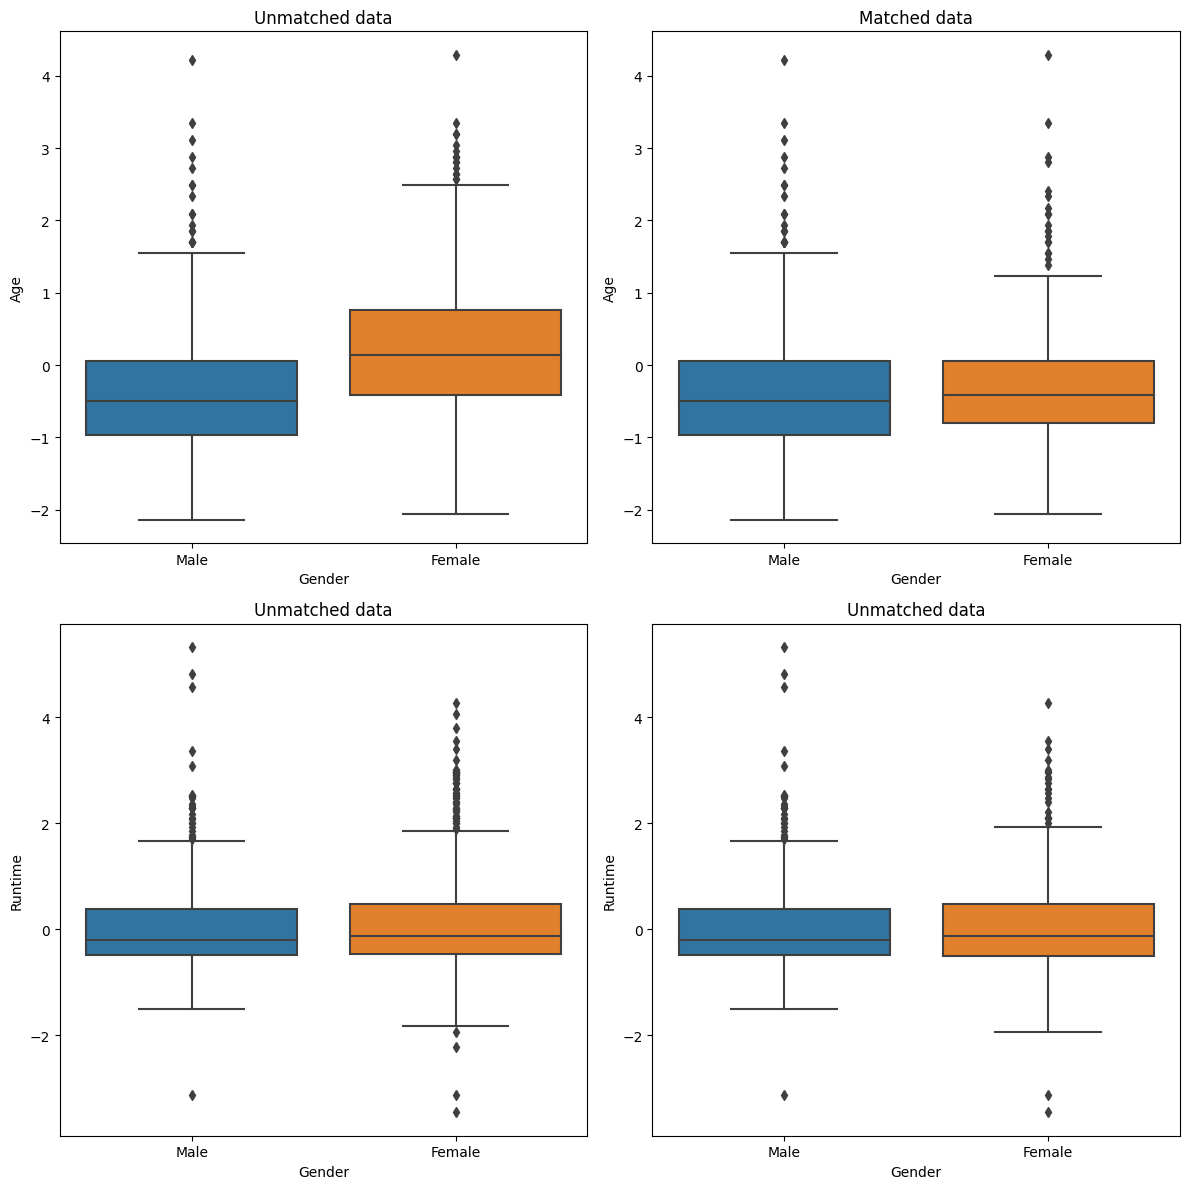

In [80]:
plot_boxplots(data_for_propensity, matching, 'Gender', 'Age', 'Runtime')

We can see that the data is more balanced, so the treatment and control groups now only majorly differ on the gender. We are now ready to plot the same histograms as before matching, showing the differences in revenue/rating depending on primary role gender.

First, we filter the 10 most common genres:

In [77]:
new_plotting_data = filter_n_common(data_for_propensity, 10, 'Genres')

new_plotting_data.head()

,Wiki ID,Year,Revenue,Runtime,Language,Country,Genres,Rating,Wins,Nominations,Height,Age,Gender,Role,Score
0,975900,0.430066,14010832.0,-0.310024,English Language,United States of America,"[Thriller, Adventure, Action]",4.9,-0.340926,-0.280944,1.78,-0.649756,0.0,Primary,0.549258
1,171005,-0.188036,10161099.0,1.098661,English Language,United Kingdom,[Drama],7.5,0.764365,0.343217,1.77,-0.571317,1.0,Primary,0.611201
2,29772142,0.893644,29381649.0,0.123418,Malayalam Language,India,[Drama],6.1,-0.340926,-0.394428,1.65,-0.806633,0.0,Primary,0.514540
3,2154704,-0.342562,3600000.0,-0.454504,English Language,United States of America,"[Thriller, Adventure]",5.2,-0.340926,-0.394428,1.85,0.213070,1.0,Primary,0.711628
5,103021,-0.754631,394589888.0,0.520739,French Language,United States of America,"[Thriller, Indie, Crime Fiction, Drama, Advent...",7.5,1.224903,0.399959,1.75,-0.571317,1.0,Primary,0.613859


Then, we revert the binary role to the 'Male' and 'Female' values for plotting sake, and then plot the histograms:

C:\Users\aouzi\AppData\Local\Temp\ipykernel_3712\2074203989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_plotting_data['Gender'] = new_plotting_data['Gender'].replace({1: 'Male', 0: 'Female'})


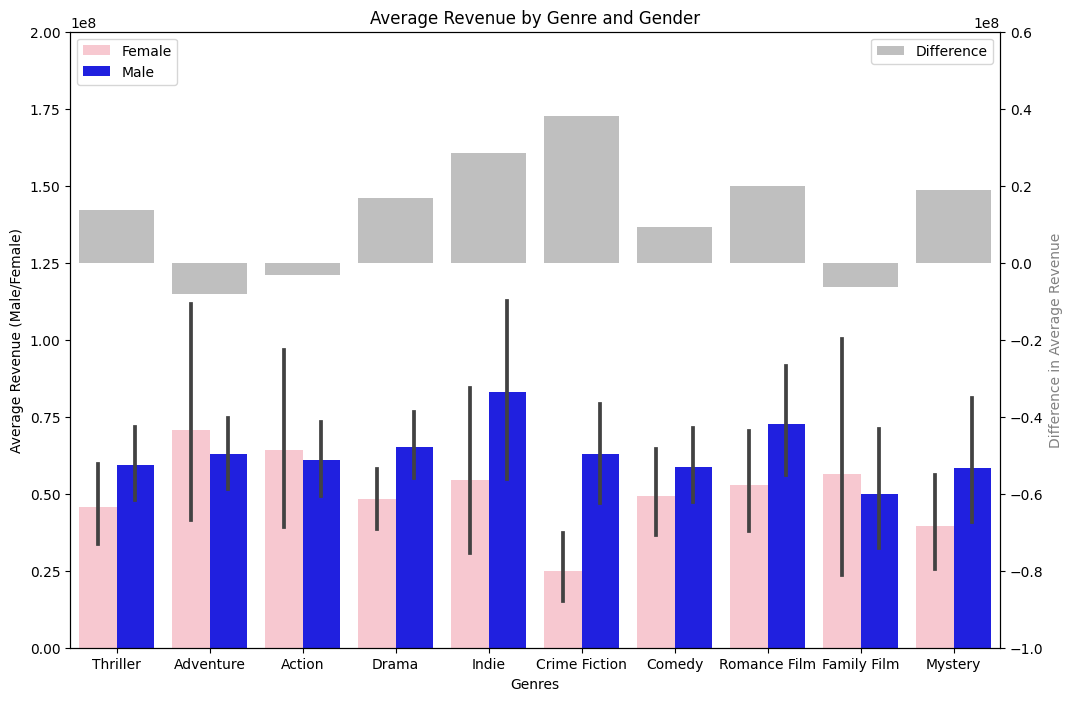

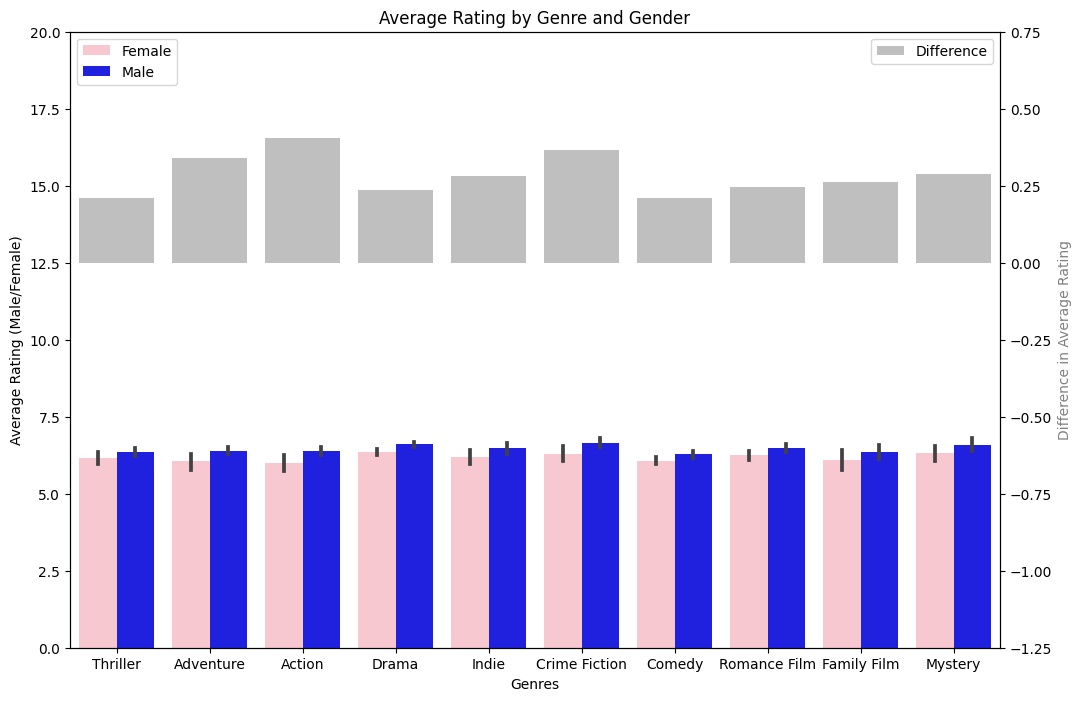

In [78]:
new_plotting_data['Gender'] = new_plotting_data['Gender'].replace({1: 'Male', 0: 'Female'})

plot_gender_revenue_difference(new_plotting_data, 'Revenue')
plot_gender_revenue_difference(new_plotting_data, 'Rating')

We can see that differences in revenue and rating still remain even after the matching, which gives us more cetitude that they are caused by the gender of the primary role in the movie. Furthermore, we see that many movie genres feature a better average revenue with female primary actors (Adventure, Action, Family Film).

It is important to know that, even though the matching was successful, we can never be sure that the difference in revenue/rating is caused solely by gender, since we couldn't match on every observed covariates, and there might be some unobserved covariates in the situation.

Either way, we conclude that actor gender is important in predicting the commercial and financial success of a movie.

### Part 3.2: Space study

### Part 3.3: Time study

### Part 3.4: Ethnicity study

## Part 4: Modelling

### Part 4.1: Input analysis

### Part 4.2: Hyperparameter tuning

### Part 4.3: Model training and testing

### Part 3.4: Model utilization (fun part)